In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\reid-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset_faces = torchvision.datasets.ImageFolder('./data/atnt-faces/train',
                                                 transform=transform)
dataset_train = reid.datasets.paired.DoublePairedVisionDataset(
    dataset_faces)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=256,
                                               shuffle=True,
                                               num_workers=0)

In [5]:
# Create Model
model = reid.models.resnet18_custom(True)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.to(device)
criterion = reid.losses.ContrastiveLoss(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Or Load
# model = reid.models.resnet18_custom(False)
# model.load_state_dict(torch.load('./model_epoch_49.pth'))
# model = model.to(device).eval()

In [7]:
# Train
loss_epoch = []
num_epochs = 100
for epoch in range(num_epochs):
    loss_batch = 0.0
    lr_sche.step()
    for i, batch in enumerate(dataloader_train, 0):
        inputs0, inputs1, labels = batch
        inputs0 = inputs0.to(device)
        inputs1 = inputs1.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = criterion(model(inputs0), model(inputs1), labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        loss_batch += loss
    loss_batch /= i+1
    print(f'epoch: {epoch}, loss: {loss_batch}')
    loss_epoch.append(loss_batch)

    if epoch % 10 == 9:
        torch.save(model.state_dict(), "./contrastive_res18_faces_epoch_{}.pth".format(epoch))

epoch: 0, loss: 742.8421630859375
epoch: 1, loss: 44.016929626464844
epoch: 2, loss: 6.361623764038086
epoch: 3, loss: 5.659379482269287
epoch: 4, loss: 5.130437850952148
epoch: 5, loss: 5.347474098205566
epoch: 6, loss: 4.891260147094727
epoch: 7, loss: 4.911073684692383
epoch: 8, loss: 4.894728660583496
epoch: 9, loss: 4.679033279418945
epoch: 10, loss: 4.713359832763672
epoch: 11, loss: 4.712115287780762
epoch: 12, loss: 4.691757678985596
epoch: 13, loss: 4.683549880981445
epoch: 14, loss: 4.665820121765137
epoch: 15, loss: 4.57843017578125
epoch: 16, loss: 4.557843208312988
epoch: 17, loss: 4.504963397979736
epoch: 18, loss: 4.49947452545166
epoch: 19, loss: 4.395631790161133
epoch: 20, loss: 4.588285446166992
epoch: 21, loss: 4.508607387542725
epoch: 22, loss: 4.5390520095825195
epoch: 23, loss: 4.400584697723389
epoch: 24, loss: 4.474550247192383
epoch: 25, loss: 4.428328990936279
epoch: 26, loss: 4.455588340759277
epoch: 27, loss: 4.536975860595703
epoch: 28, loss: 4.37797403335

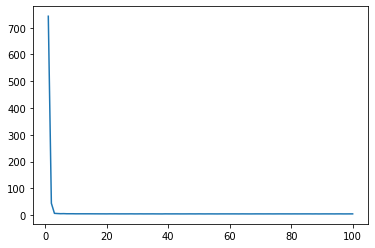

In [8]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_epoch)
plt.show()

In [9]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        other = others[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_other = model(other)
        distance = torch.nn.functional.pairwise_distance(
            output_anchor, output_other)

        # make grid
        imgs = torch.cat((transform(anchor), transform(other)), 0)
        plt.imshow(
            torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'dist: {:.8f}'.format(distance.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

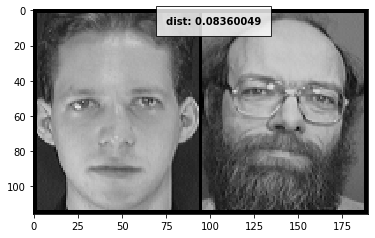

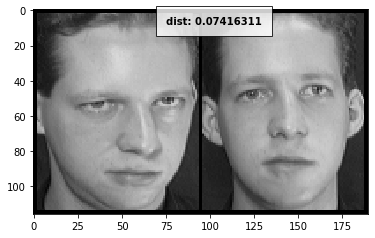

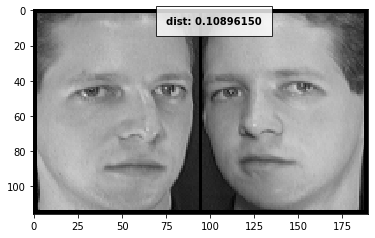

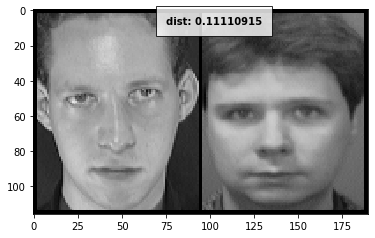

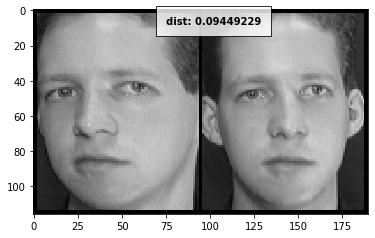

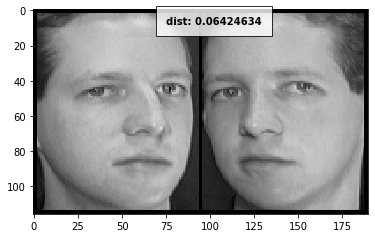

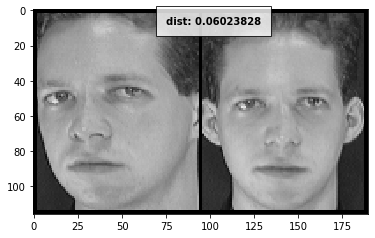

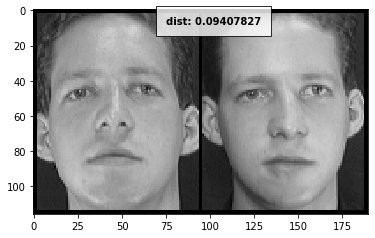

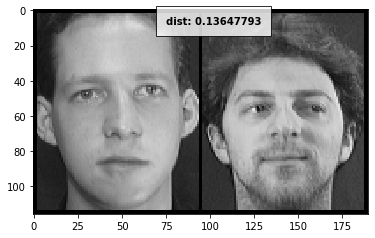

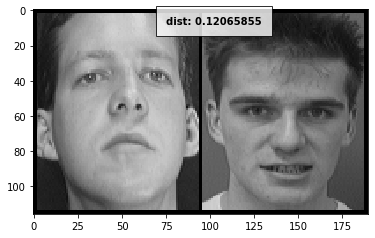

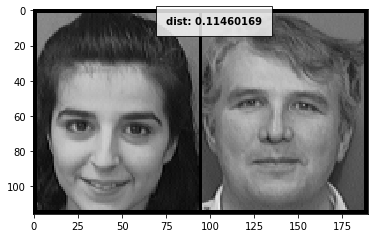

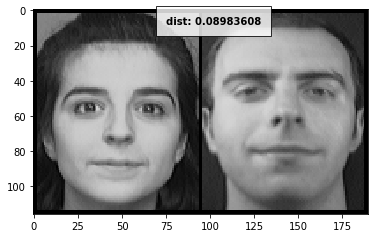

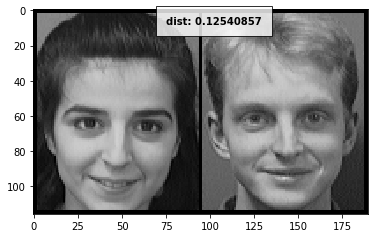

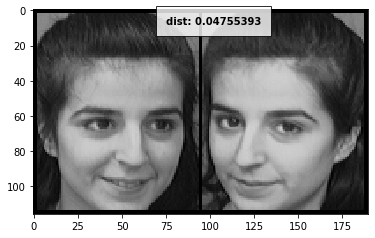

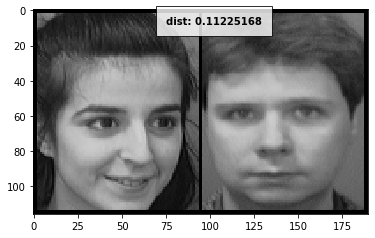

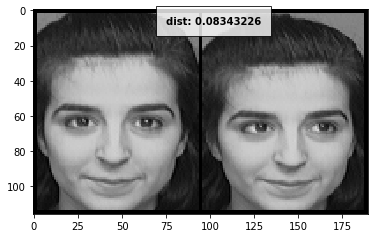

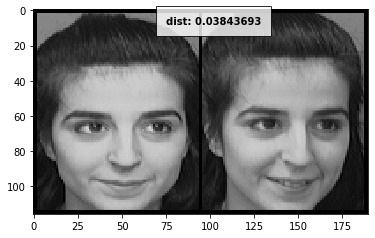

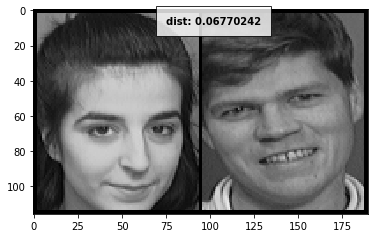

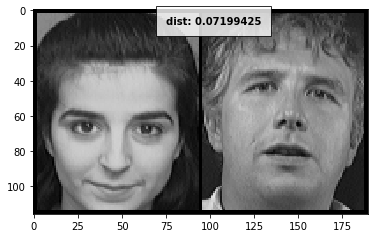

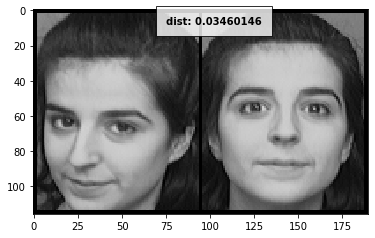

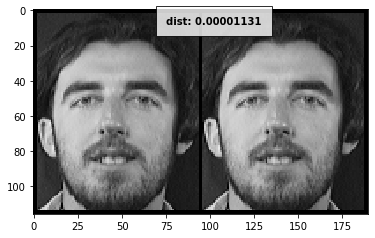

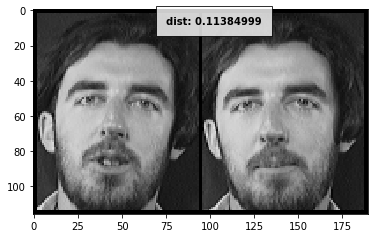

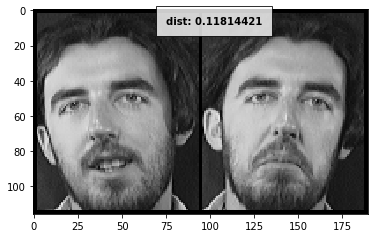

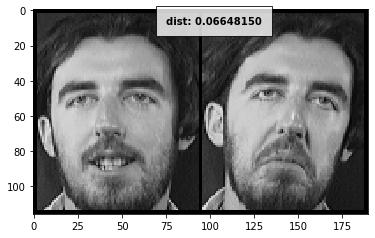

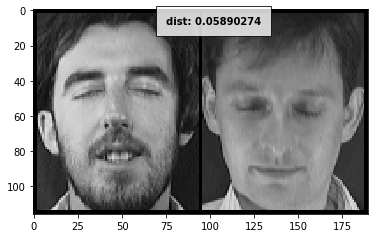

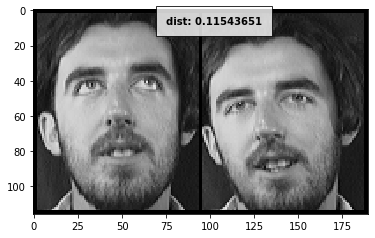

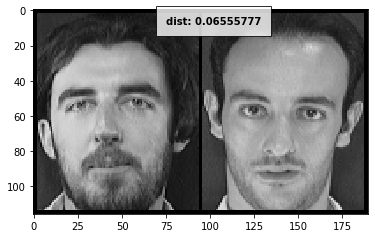

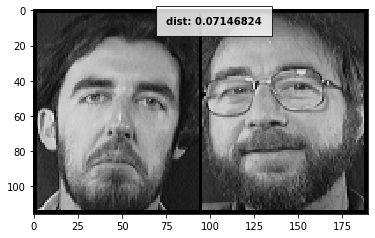

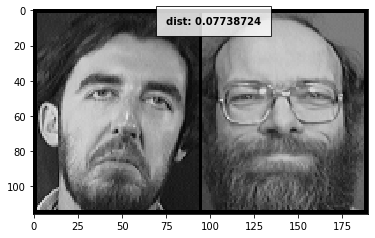

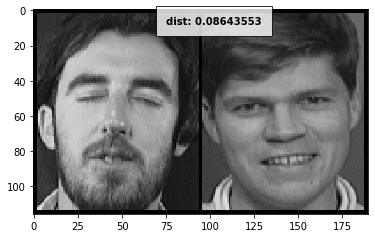

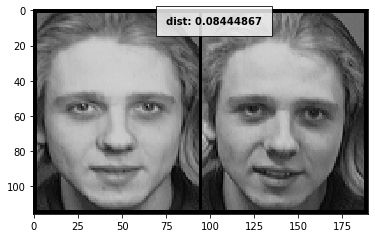

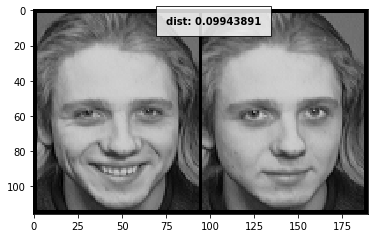

In [10]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)